In [2]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()

api_key=os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0,api_key=api_key)

llm.invoke("How to learn system design as a backend developer?").content



'Learning system design as a backend developer is a crucial step in advancing your career, especially if you\'re aiming for roles like software architect or senior developer. Here’s a structured approach to help you learn system design effectively:\n\n### 1. **Understand the Basics of System Design**\n   - **What is System Design?**: Learn the fundamental concepts, including scalability, reliability, availability, and maintainability.\n   - **Key Components**: Familiarize yourself with components like databases, caching, load balancers, message queues, and microservices.\n\n### 2. **Study Design Principles**\n   - **SOLID Principles**: Understand the principles of object-oriented design.\n   - **Design Patterns**: Learn common design patterns (e.g., Singleton, Factory, Observer) and when to use them.\n   - **Microservices vs. Monoliths**: Understand the pros and cons of different architectural styles.\n\n### 3. **Learn About Scalability**\n   - **Vertical vs. Horizontal Scaling**: Unde

# **ToolNode**


## **Imports libraries**


In [37]:
from langgraph.graph import MessagesState,StateGraph,START,END
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import tools_condition
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from datetime import datetime
from IPython.display import Image, display


## **Memory adding**


In [51]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## **States**


In [38]:
class MyState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## **Tools**


In [39]:
@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers"""
    return a - b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b


@tool
def divide(a: int, b: int) -> float:
    """Divide two numbers"""
    if b == 0:
        return "Error: Division by zero"
    return a / b

@tool
def get_current_time() -> str:
    """Get the current time"""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")


@tool
def get_current_date() -> str:
    """Get the current date"""
    return datetime.now().strftime("%Y-%m-%d")


@tool
def get_current_day() -> str:
    """Get the current day of the week"""
    return datetime.now().strftime("%A")

tools = [add, subtract, multiply, divide, get_current_time, get_current_date, get_current_day]
llm_with_tools = llm.bind_tools(tools)


## **Binds tools with LLM**


In [40]:
def tool_calling_llm(state: MyState) -> MyState:
    """Call the LLM to get the result"""
    messages = state["messages"]
    llm_response = llm_with_tools.invoke(messages)
    return {"messages": [llm_response]}

## **Graph Builder**


In [53]:
builder = StateGraph(MyState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
workflow = builder.compile(checkpointer=memory)

## **Graph**


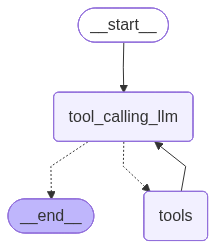

In [54]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [57]:
user_input = [HumanMessage(content="Now divide the previous result by 2")]
config={"configurable":{"thread_id":"123"}}
message=workflow.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hey buddy, Multiply 2 and 3 and then multiply the result with 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_sw5WRwslCYr8xYkfC0yrSEJt)
 Call ID: call_sw5WRwslCYr8xYkfC0yrSEJt
  Args:
    a: 2
    b: 3
  multiply (call_JbiOwjeNzdoQJEUCJsORu6lB)
 Call ID: call_JbiOwjeNzdoQJEUCJsORu6lB
  Args:
    a: 6
    b: 4
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: multiply

24
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6. Then, multiplying that result (6) by 4 gives us 24.
================================ Human Message =================================

Now divide the previous result by 2
================================== Ai Message ======

1. Add Message reducer =>add_messages
2. Remove message =>RemoveMessage


## **Chatbot summarization**


In [144]:
from langchain_core.messages import SystemMessage,RemoveMessage
class ChatbotSummary(MessagesState):
    summary: str

In [145]:
def call_model(state: ChatbotSummary) -> ChatbotSummary:
    summary = state["messages"]
    
    if summary:
        # Add summary to the system message
        system_message = f"Here is the summary of the conversation: {summary}"
        messages = [SystemMessage(content=system_message)]+state["messages"]
    else:
        messages = state["messages"]
    llm_response = llm.invoke(messages)
    return {"messages": llm_response}

In [146]:
def summarize_conversation(state: ChatbotSummary) -> ChatbotSummary:
    summary = state["messages"]
    
    if summary:
        # Add summary to the system message
        system_message = (
            f"Here is the summary of the conversation:\n\n {summary}"
            "Extend the summary to include the latest conversation"
        )
    else:
        system_message = "Create a summary of the conversation above"
        
    messages = state["messages"]+[HumanMessage(content=system_message)]
    llm_response = llm.invoke(messages).content
    
    delete_message = [RemoveMessage(id=msg.id) for msg in state["messages"][:-2]]
    return {"summary":llm_response,"messages":delete_message}

In [147]:
from langgraph.graph import MessagesState,StateGraph,START,END

def should_continue(state: ChatbotSummary) -> str:
    """Determine whether to continue or not"""
    messages = state["messages"]
    
    if len(messages) > 6:
        result = "summarize_conversation"
    else:
        result = "end"
    
    return result

In [148]:
workflow = StateGraph(ChatbotSummary)

workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "end": END
    }
)

workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

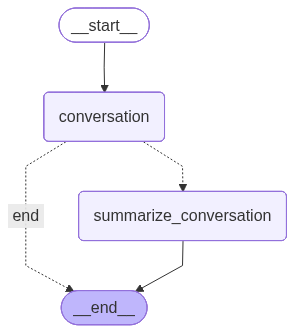

In [149]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [150]:
config={"configurable":{"thread_id":"123345"}}

In [151]:
user_input=[HumanMessage(content="Hii my name is EHtsham")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="What is my name?")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="I like to play bedminton")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Nice to meet you. How can I assist you today?
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Nice to meet you. How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Ehtsham.
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Nice to meet you. How can I assist you today?
================================ Human Message ===============

In [152]:
graph.get_state(config).values.get("summary")

In [153]:
user_input=[HumanMessage(content="I like hi Yuqi from China, is he the best player in the world?")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

I like hi Yuqi from China, is he the best player in the world?
================================== Ai Message ==================================

Hi Yuqi is a talented badminton player, and he has achieved significant success in his career. However, whether he is considered the "best" player in the world can vary depending on current rankings and opinions. As of my last update, players like Kento Momota and Viktor Axelsen have also been regarded as top players. Rankings can change frequently, so it's always good to check the latest updates!


In [154]:
graph.get_state(config).values.get("summary")

'Sure! Here’s an extended summary of our conversation, including the latest exchanges:\n\n1. **Ehtsham Introduces Himself**: Ehtsham greets and shares his name.\n2. **AI Responds**: The AI responds warmly, asking how it can assist Ehtsham.\n3. **Ehtsham Asks About His Name**: Ehtsham inquires about his name.\n4. **AI Confirms Name**: The AI confirms that his name is Ehtsham.\n5. **Ehtsham Shares His Interest**: Ehtsham mentions that he likes to play badminton.\n6. **AI Responds Positively**: The AI acknowledges that badminton is a fun sport and asks how often Ehtsham plays.\n7. **Ehtsham Mentions Hi Yuqi**: Ehtsham expresses his admiration for Hi Yuqi from China and asks if he is the best player in the world.\n8. **AI Provides Information**: The AI responds that Hi Yuqi is a talented player but notes that the title of "best player" can vary based on rankings and opinions, mentioning other top players like Kento Momota and Viktor Axelsen.\n\nIf there\'s anything else you\'d like to add 

# **SQLlite memory**


In [155]:
import sqlite3

connection = sqlite3.connect(":memory:")

In [156]:
db_path = "memory.db"
connection = sqlite3.connect(db_path,check_same_thread=False)

In [157]:
from langgraph.checkpoint.sqlite import SqliteSaver

checkpointer = SqliteSaver(connection)


In [158]:
workflow = StateGraph(ChatbotSummary)

workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "end": END
    }
)

workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

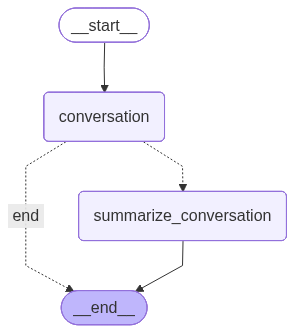

In [159]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [160]:
config={"configurable":{"thread_id":"sqlite_memory"}}

In [161]:
user_input=[HumanMessage(content="Hii my name is EHtsham")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="What is my name?")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="I like to play bedminton")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Welcome back! How can I assist you today?
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Welcome back! How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Ehtsham.
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Welcome back! How can I assist you today?
================================ Human Message ===========================

In [162]:
graph.get_state(config).values.get("summary")

'Sure! Here’s an extended summary of the conversation, including the latest exchanges:\n\n1. **User Introduction**: Ehtsham introduces himself.\n   - **User**: "Hii my name is EHtsham"\n   - **AI**: "Hi Ehtsham! Nice to meet you. How can I assist you today?"\n\n2. **Name Confirmation**: Ehtsham asks for confirmation of his name.\n   - **User**: "What is my name?"\n   - **AI**: "Your name is Ehtsham."\n\n3. **Interest in Badminton**: Ehtsham shares his interest in badminton.\n   - **User**: "I like to play bedminton."\n   - **AI**: "That\'s great! Badminton is a fun and fast-paced sport. How often do you play?"\n\n4. **Reintroduction**: Ehtsham reintroduces himself.\n   - **User**: "Hii my name is EHtsham."\n   - **AI**: "Hi Ehtsham! Welcome back! How can I assist you today?"\n\nIf there\'s anything specific you\'d like to add or discuss further, let me know!'

# **Streaming Response**


In [166]:
config_stream={"configurable":{"thread_id":"streaming_response"}}
user_input=[HumanMessage(content="Hii my name is EHtsham")]

for chunks in graph.stream({"messages": user_input},config_stream,stream_mode="update"):
    print(chunks)


In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()




llm = ChatOpenAI(model="gpt-4o-mini",api_key=os.getenv("OPENAI_API_KEY"))

# llm.invoke("How to learn system design as a backend developer?").content



In [2]:
llm.invoke("How to learn system design as a backend developer?").content

'Learning system design as a backend developer is an important step towards building scalable, robust, and efficient systems. Here’s a structured approach to help you get started:\n\n### 1. Understand Core Concepts\n- **Learn the Basics**: Understand fundamental concepts such as scalability, reliability, maintainability, and performance. Get a grasp on key principles of software engineering like SOLID principles, DRY (Don\'t Repeat Yourself), KISS (Keep It Simple, Stupid), etc.\n  \n- **Know the Components**:\n  - Distributed Systems: Understand how distributed systems work and their trade-offs.\n  - Databases: Get familiar with SQL vs. NoSQL, data modeling, indexing, and transactions.\n  - Caching: Learn about caching strategies and tools (e.g., Redis, Memcached).\n  - Load Balancers: Understand how load balancers work and their role in distributing traffic.\n  - Message Queues: Familiarize yourself with asynchronous communication through message queues (e.g., RabbitMQ, Kafka).\n  - M

In [14]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import tool
from datetime import datetime
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

In [15]:
class MyState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [16]:
def assistant(state: MyState) -> MyState:
    messages = state["messages"]
    llm_response = llm.invoke(messages)
    return {"messages": [llm_response]}

In [18]:
workflow = StateGraph(MyState)
workflow.add_node("assistant", assistant)
workflow.add_edge(START, "assistant")
workflow.add_edge("assistant", END)

graph = workflow.compile(checkpointer=MemorySaver())

In [32]:
from langchain_core.messages import HumanMessage
config={"configurable":{"thread_id":"123"}}
user_input=[HumanMessage(content="Hii my name is EHtsham")]

# for chunks in graph.stream({"messages": user_input},config,stream_mode="update"):
#     print(chunks)

async for events in graph.astream_events({"messages": user_input}, config, version="v2"):
    print(f"Node: {events.get('metadata', {}).get('langgraph_node')}. Type: {events.get('event')}. Name: {events.get('name')}")

Node: None. Type: on_chain_start. Name: LangGraph
Node: assistant. Type: on_chain_start. Name: assistant
Node: assistant. Type: on_chat_model_start. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_ch

In [34]:
from langchain_core.messages import HumanMessage

node_to_stream = "conversation"  # set to your actual node id
config = {"configurable": {"thread_id": "123abc"}}
user_input = [HumanMessage(content="what is the capital of Pakistan?")]

async for event in graph.astream_events({"messages": user_input}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node") == node_to_stream:
        data = event.get("data", {})
        print(data.get("chunk") or data)


# **Interrupt and Human in Loop**


In [31]:
from langchain.tools import tool
from langgraph.graph import StateGraph,END,START,MessagesState,add_messages
from langchain_core.messages import HumanMessage
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from typing import TypedDict

In [32]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]    

In [33]:
@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers"""
    return a - b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b


@tool
def divide(a: int, b: int) -> float:
    """Divide two numbers"""
    if b == 0:
        return "Error: Division by zero"
    return a / b

@tool
def get_current_time() -> str:
    """Get the current time"""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")


@tool
def get_current_date() -> str:
    """Get the current date"""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d")


@tool
def get_current_day() -> str:
    """Get the current day of the week"""
    return datetime.now().strftime("%A")

tools = [add, subtract, multiply, divide, get_current_time, get_current_date, get_current_day]
llm_with_tools = llm.bind_tools(tools)


In [34]:
def tool_calling_llm(state: MyState) -> MyState:
    """Call the LLM to get the result"""
    messages = state["messages"]
    llm_response = llm_with_tools.invoke(messages)
    return {"messages": [llm_response]}

In [35]:
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

builder = StateGraph(MyState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
workflow = builder.compile(interrupt_before=["tools"],checkpointer=memory)

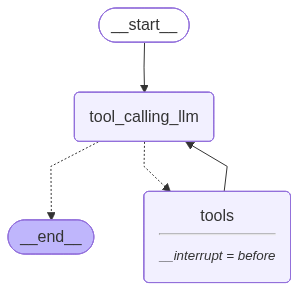

In [47]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [36]:
initial_messages = [HumanMessage(content="What is current date and time.")]
config={"configurable":{"thread_id":"1234"}}

for event in workflow.stream({"messages": initial_messages},config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is current date and time.
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_X7c5EfV60hXgGHuCo8Y2gmqv)
 Call ID: call_X7c5EfV60hXgGHuCo8Y2gmqv
  Args:
  get_current_time (call_HBHP5HwCsDd9Lx8L3lzMzWUA)
 Call ID: call_HBHP5HwCsDd9Lx8L3lzMzWUA
  Args:


In [37]:
state=workflow.get_state(config)
state.next

('tools',)

In [38]:
for events in workflow.stream(None,config,stream_mode="values"):
    events["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_X7c5EfV60hXgGHuCo8Y2gmqv)
 Call ID: call_X7c5EfV60hXgGHuCo8Y2gmqv
  Args:
  get_current_time (call_HBHP5HwCsDd9Lx8L3lzMzWUA)
 Call ID: call_HBHP5HwCsDd9Lx8L3lzMzWUA
  Args:
================================= Tool Message =================================
Name: get_current_time

2025-10-26 10:41:22
================================== Ai Message ==================================

The current date is October 26, 2025, and the current time is 10:41:22.


In [55]:
config={"configurable":{"thread_id":"1234"}}

In [56]:
initial_messages = [HumanMessage(content="What is current date and time.and what if we muliply 18 and 8 and then add 10 to it")]

for event in workflow.stream({"messages": initial_messages},config,stream_mode="values"):
    event["messages"][-1].pretty_print()
    
user_approval = input("Do you want to continue? Yes/No")
if user_approval == "yes":
    for events in workflow.stream(None,config,stream_mode="values"):
        events["messages"][-1].pretty_print()
    
else:
    print("Workflow interrupted")

================================ Human Message =================================

What is current date and time.and what if we muliply 18 and 8 and then add 10 to it
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_9EDkuQRaF2pAQ3VN9RmnQghm)
 Call ID: call_9EDkuQRaF2pAQ3VN9RmnQghm
  Args:
  get_current_time (call_uGsODUFQRgmE7wjsXjmOyocU)
 Call ID: call_uGsODUFQRgmE7wjsXjmOyocU
  Args:
  multiply (call_yWbMeiGj2JyYp2OHuPI11Plz)
 Call ID: call_yWbMeiGj2JyYp2OHuPI11Plz
  Args:
    a: 18
    b: 8
  add (call_GKvQfWNG6Oo47XyufRJg6lVQ)
 Call ID: call_GKvQfWNG6Oo47XyufRJg6lVQ
  Args:
    a: 144
    b: 10
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_9EDkuQRaF2pAQ3VN9RmnQghm)
 Call ID: call_9EDkuQRaF2pAQ3VN9RmnQghm
  Args:
  get_current_time (call_uGsODUFQRgmE7wjsXjmOyocU)
 Call ID: call_uGsODUFQRgmE7wjsXjmOyocU
  Args:
  multiply (call_yWbMeiGj2JyYp2OHuP

In [57]:
initial_messages = [HumanMessage(content="What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it")]

for event in workflow.stream({"messages": initial_messages},config,stream_mode="values"):
    event["messages"][-1].pretty_print()
    
user_approval = input("Do you want to continue? Yes/No")
if user_approval == "yes":
    for events in workflow.stream(None,config,stream_mode="values"):
        events["messages"][-1].pretty_print()
    
else:
    print("Workflow interrupted")

================================ Human Message =================================

What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_rdxbHmVAwJu9oqCXaFatWp2G)
 Call ID: call_rdxbHmVAwJu9oqCXaFatWp2G
  Args:
  get_current_time (call_xsAcwG696tH6uLPx9qDCYgF5)
 Call ID: call_xsAcwG696tH6uLPx9qDCYgF5
  Args:
  multiply (call_zvL4L7F39PRrwQ4dh6ZhXVrx)
 Call ID: call_zvL4L7F39PRrwQ4dh6ZhXVrx
  Args:
    a: 18
    b: 8
  divide (call_Js2IeP8rjsAl3GKERRVlDJyn)
 Call ID: call_Js2IeP8rjsAl3GKERRVlDJyn
  Args:
    a: 144
    b: 10
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_rdxbHmVAwJu9oqCXaFatWp2G)
 Call ID: call_rdxbHmVAwJu9oqCXaFatWp2G
  Args:
  get_current_time (call_xsAcwG696tH6uLPx9qDCYgF5)
 Call ID: call_xsAcwG696tH6uLPx9qDCYgF5
  Args:
  multiply (call_zvL4L7F39

In [59]:
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

builder = StateGraph(MyState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile(interrupt_before=["tool_calling_llm"],checkpointer=memory)

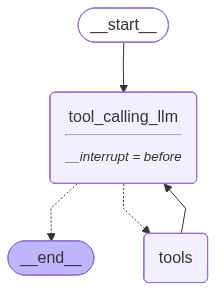

In [60]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
user_input = [HumanMessage(content="What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it")]

config={"configurable":{"thread_id":"123@@"}}

In [62]:
for event in graph.stream({"messages": user_input},config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it


In [63]:
state=graph.get_state(config)
state

StateSnapshot(values={'messages': [HumanMessage(content='What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it', additional_kwargs={}, response_metadata={}, id='852f9bff-8b94-4021-9efe-2d717deac264')]}, next=('tool_calling_llm',), config={'configurable': {'thread_id': '123@@', 'checkpoint_ns': '', 'checkpoint_id': '1f0adcad-fe54-6b52-8000-4b1e4774463a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-20T15:38:49.983036+00:00', parent_config={'configurable': {'thread_id': '123@@', 'checkpoint_ns': '', 'checkpoint_id': '1f0adcad-fe51-68e5-bfff-b84c21408a0c'}}, tasks=(PregelTask(id='d453c944-77d5-5230-2f05-475dc8f5daf2', name='tool_calling_llm', path=('__pregel_pull', 'tool_calling_llm'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [66]:
graph.update_state(
    config,
    {"messages": [HumanMessage(content="No,Actually I want to add 20+19")]},
)
    

{'configurable': {'thread_id': '123@@',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0adcb4-c18f-613e-8004-8aa1f0438ac5'}}

In [67]:
new_state=graph.get_state(config).values
for msg in new_state["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it
================================ Human Message =================================

No,Actually I want to add 20+19
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_hJJhMFoOcnNOkIRcTujzOyCj)
 Call ID: call_hJJhMFoOcnNOkIRcTujzOyCj
  Args:
  get_current_time (call_qu0GjlQDbMDg65NFgeWcm80X)
 Call ID: call_qu0GjlQDbMDg65NFgeWcm80X
  Args:
  multiply (call_LntTLRBs8KcYM8aUCPchnkHu)
 Call ID: call_LntTLRBs8KcYM8aUCPchnkHu
  Args:
    a: 18
    b: 8
  add (call_cJOpozterShHF0byK54ofGfh)
 Call ID: call_cJOpozterShHF0byK54ofGfh
  Args:
    a: 20
    b: 19
================================= Tool Message =================================
Name: get_current_date

2025-10-20
================================= Tool Message =================================
Name: get_

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()


True

In [2]:
from langchain_openai import ChatOpenAI
openai_api_key = os.getenv("OPENAI_API_KEY")


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm.invoke("How to learn system design as a backend developer?").content

'Learning system design as a backend developer is a crucial step in advancing your career, especially if you\'re aiming for roles like software architect or senior developer. Here’s a structured approach to help you learn system design effectively:\n\n### 1. **Understand the Basics of System Design**\n   - **What is System Design?**: Familiarize yourself with the concepts of system design, including scalability, reliability, maintainability, and performance.\n   - **Key Components**: Learn about the fundamental components of system design, such as databases, caching, load balancers, message queues, and microservices.\n\n### 2. **Study Design Principles**\n   - **SOLID Principles**: Understand the SOLID principles of object-oriented design.\n   - **Design Patterns**: Learn common design patterns (e.g., Singleton, Factory, Observer) and when to use them.\n   - **Microservices vs. Monoliths**: Understand the differences, advantages, and disadvantages of microservices architecture compared

# **Human Interruption**


In [25]:
from langchain_core.tools import tool
from langgraph.graph import StateGraph,END,START,MessagesState,add_messages
from langchain_core.messages import HumanMessage,AnyMessage
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from typing import TypedDict,Annotated
from langgraph.prebuilt import tools_condition
import datetime

In [11]:
class MyState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [39]:
@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers"""
    return a - b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b


@tool
def divide(a: int, b: int) -> float:
    """Divide two numbers"""
    if b == 0:
        return "Error: Division by zero"
    return a / b

@tool
def get_current_time() -> str:
    """Get the current time"""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")


@tool
def get_current_date() -> str:
    """Get the current date"""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d")


@tool
def get_current_day() -> str:
    """Get the current day of the week"""
    return datetime.now().strftime("%A")

tools = [add, subtract, multiply, divide, get_current_time, get_current_date, get_current_day]
llm_with_tools = llm.bind_tools(tools)


In [41]:
def assistant(state: MyState) -> MyState:
    messages = state["messages"]
    llm_response = llm_with_tools.invoke(messages)
    return {"messages": [llm_response]}

## **Interrupt before tools**


In [42]:
workflow = StateGraph(MyState)
workflow.add_node("assistant", assistant)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "assistant")
workflow.add_edge("assistant", "tools")
workflow.add_edge("tools", "assistant")
workflow.add_conditional_edges(
    "assistant",
    tools_condition,
)
workflow.add_edge("assistant", END)

graph = workflow.compile(interrupt_before=["tools"],checkpointer=MemorySaver())


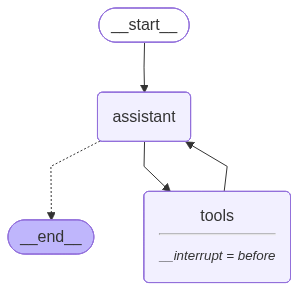

In [43]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
config={"configurable":{"thread_id":"123##"}}
user_input = [HumanMessage(content="What is current date and time")]

for event in graph.stream({"messages": user_input},config,stream_mode="values"):
    event["messages"][-1].pretty_print()   

================================ Human Message =================================

What is current date and time
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_BMvfHgMecUIxDRtmk01NvQ6r)
 Call ID: call_BMvfHgMecUIxDRtmk01NvQ6r
  Args:
  get_current_time (call_g2ehggufoszgAushmqLkvfRx)
 Call ID: call_g2ehggufoszgAushmqLkvfRx
  Args:


In [45]:
state=graph.get_state(config)
state.next

('tools',)

In [46]:
for events in graph.stream(None,config,stream_mode="values"):
    events["messages"][-1].pretty_print()
# None is the message
# config is the previous thread id

================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_BMvfHgMecUIxDRtmk01NvQ6r)
 Call ID: call_BMvfHgMecUIxDRtmk01NvQ6r
  Args:
  get_current_time (call_g2ehggufoszgAushmqLkvfRx)
 Call ID: call_g2ehggufoszgAushmqLkvfRx
  Args:
================================= Tool Message =================================
Name: get_current_time

2025-10-26 10:42:20
================================== Ai Message ==================================

The current date is October 26, 2025, and the current time is 10:42:20.


In [47]:
config={"configurable":{"thread_id":"1234@@"}}
user_input = [HumanMessage(content="What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it")]

for event in graph.stream({"messages": user_input},config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_LIZdq4TENpP0eLDk4sJDYN9D)
 Call ID: call_LIZdq4TENpP0eLDk4sJDYN9D
  Args:
  get_current_time (call_9zYiCNobVwpqKxkePZCA8AZv)
 Call ID: call_9zYiCNobVwpqKxkePZCA8AZv
  Args:
  multiply (call_UN8xWJBb4gbcfV8lpPgIxSbO)
 Call ID: call_UN8xWJBb4gbcfV8lpPgIxSbO
  Args:
    a: 18
    b: 8
  divide (call_nVErZbm5yOgMKdLiUnDn0Ajk)
 Call ID: call_nVErZbm5yOgMKdLiUnDn0Ajk
  Args:
    a: 144
    b: 10


In [ ]:
state2 = graph.get_state(config)
state2.next

('tools',)

In [49]:
for events in graph.stream(None,config,stream_mode="values"):
    events["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_LIZdq4TENpP0eLDk4sJDYN9D)
 Call ID: call_LIZdq4TENpP0eLDk4sJDYN9D
  Args:
  get_current_time (call_9zYiCNobVwpqKxkePZCA8AZv)
 Call ID: call_9zYiCNobVwpqKxkePZCA8AZv
  Args:
  multiply (call_UN8xWJBb4gbcfV8lpPgIxSbO)
 Call ID: call_UN8xWJBb4gbcfV8lpPgIxSbO
  Args:
    a: 18
    b: 8
  divide (call_nVErZbm5yOgMKdLiUnDn0Ajk)
 Call ID: call_nVErZbm5yOgMKdLiUnDn0Ajk
  Args:
    a: 144
    b: 10
================================= Tool Message =================================
Name: divide

14.4
================================== Ai Message ==================================

The current date is **October 26, 2025**, and the current time is **10:42:59**.

When you multiply 18 and 8, you get **144**. If you then divide that by 10, the result is **14.4**.


In [50]:
user_input = input("Enter your message")

user_input = [HumanMessage(content=user_input)]

for event in graph.stream({"messages": user_input},config,stream_mode="values"):
    event["messages"][-1].pretty_print()
    
user_permission = input("Do you want to continue? Yes/No")
if user_permission == "yes":
    for events in graph.stream(None,config,stream_mode="values"):
        events["messages"][-1].pretty_print()
else:
    print("Workflow interrupted")

================================ Human Message =================================

What is the current date and what is the sum of 14 and 5
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_KX0otO5Bdz49avlw3L8qsLji)
 Call ID: call_KX0otO5Bdz49avlw3L8qsLji
  Args:
  add (call_MnDSxuImaSrlZKnpl2Uf84id)
 Call ID: call_MnDSxuImaSrlZKnpl2Uf84id
  Args:
    a: 14
    b: 5
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_KX0otO5Bdz49avlw3L8qsLji)
 Call ID: call_KX0otO5Bdz49avlw3L8qsLji
  Args:
  add (call_MnDSxuImaSrlZKnpl2Uf84id)
 Call ID: call_MnDSxuImaSrlZKnpl2Uf84id
  Args:
    a: 14
    b: 5
================================= Tool Message =================================
Name: add

19
================================== Ai Message ==================================

The current date is **October 26, 2025**, and the sum of 14 and 5 is **19**.


# **Interruption before Assistant**


In [51]:
workflow = StateGraph(MyState)
workflow.add_node("assistant", assistant)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "assistant")
workflow.add_edge("assistant", "tools")
workflow.add_edge("tools", "assistant")
workflow.add_conditional_edges(
    "assistant",
    tools_condition,
)
workflow.add_edge("assistant", END)

graph = workflow.compile(interrupt_before=["assistant"],checkpointer=MemorySaver())


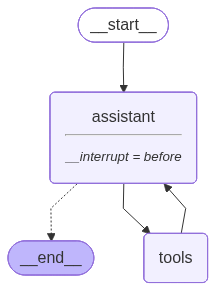

In [52]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
initial_messages = [HumanMessage(content="What is current date and time")]
config={"configurable":{"thread_id":"assistant_interruption"}}

for event in graph.stream({"messages": initial_messages},config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is current date and time


In [55]:
state=graph.get_state(config)
state

StateSnapshot(values={'messages': [HumanMessage(content='What is current date and time', additional_kwargs={}, response_metadata={}, id='7a984b26-0894-4e4e-8a42-615962ee1353')]}, next=('assistant',), config={'configurable': {'thread_id': 'assistant_interruption', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22f6-2a5e-6989-8000-d74e27bb37e3'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-26T05:48:23.673268+00:00', parent_config={'configurable': {'thread_id': 'assistant_interruption', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22f6-2a5c-6771-bfff-7c0ff6cac43c'}}, tasks=(PregelTask(id='c9c6311f-ac14-446a-c9bc-a096f271d48a', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [56]:
graph.update_state(
    config,
    {"messages": [HumanMessage(content="No,Actually I want to add 20+19")]},
)

{'configurable': {'thread_id': 'assistant_interruption',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b22f9-504e-6038-8001-a0da509b9f75'}}

In [57]:
new_state=graph.get_state(config).values
for msg in new_state["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is current date and time
================================ Human Message =================================

No,Actually I want to add 20+19


In [58]:
for events in graph.stream(None,config,stream_mode="values"):
    events["messages"][-1].pretty_print()

================================ Human Message =================================

No,Actually I want to add 20+19
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_vrECrnJ59fbOZqPS2wK9MnbT)
 Call ID: call_vrECrnJ59fbOZqPS2wK9MnbT
  Args:
  get_current_time (call_3HumKgPvIpnqoDiGoduUPHvZ)
 Call ID: call_3HumKgPvIpnqoDiGoduUPHvZ
  Args:
  add (call_v2TpzIaNmO3YrHOOwJQAc7FX)
 Call ID: call_v2TpzIaNmO3YrHOOwJQAc7FX
  Args:
    a: 20
    b: 19
================================= Tool Message =================================
Name: add

39


# **Node Interruption**


In [ ]:
from IPython.display import Image, display
from langgraph.types import interrupt
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,START,END
from typing import TypedDict

In [80]:
class NodeInterruptState(TypedDict):
    input:str

def step_1(state:NodeInterruptState) -> NodeInterruptState:
    print(f"Step 1: {state['input']}")
    return {"input":state['input']}

def step_2(state:NodeInterruptState) -> NodeInterruptState:
    if len(state["input"]) > 5:
        raise interrupt(f"Input is too long: {state['input']}")
    print(f"Step 2: {state['input']}")
    return {"input":state['input']}

def step_3(state:NodeInterruptState) -> NodeInterruptState:
    print(f"Step 3: {state['input']}")
    return {"input":state['input']}


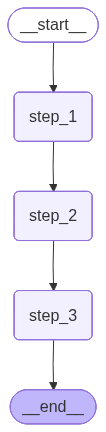

In [81]:
workflow = StateGraph(NodeInterruptState)
workflow.add_node("step_1", step_1)
workflow.add_node("step_2", step_2)
workflow.add_node("step_3", step_3)

workflow.add_edge(START, "step_1")
workflow.add_edge("step_1", "step_2")
workflow.add_edge("step_2", "step_3")
workflow.add_edge("step_3", END)

graph = workflow.compile(checkpointer=MemorySaver())
display(Image(graph.get_graph().draw_mermaid_png()))

In [85]:
input_message={"input":"Hello world"}
config_interrupt={"configurable":{"thread_id":"123455!@"}}

for event in graph.stream(input_message,config=config_interrupt,stream_mode="values"):  
    print(event)  
    
    

{'input': 'Hello world'}
Step 1: Hello world
{'input': 'Hello world'}
{'__interrupt__': (Interrupt(value='Input is too long: Hello world', id='1152e7191fc80690b465fa0c67e77752'),)}


In [86]:
state=graph.get_state(config_interrupt)
state.next

('step_2',)

In [87]:
print(state.tasks)

(PregelTask(id='e2851d49-f3c9-171b-9bd3-9abb5532c19a', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Input is too long: Hello world', id='1152e7191fc80690b465fa0c67e77752'),), state=None, result=None),)


In [90]:
graph.update_state(config_interrupt,{"input":"Hello"})

{'configurable': {'thread_id': '123455!@',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b2378-421d-6de9-800b-3c83773035d2'}}

In [91]:
for event in graph.stream(None,config=config_interrupt,stream_mode="values"):  
    print(event)  

{'input': 'Hello'}
Step 2: Hello
{'input': 'Hello'}
Step 3: Hello
{'input': 'Hello'}


# **Interrupt, command goto**


In [ ]:
from langgraph.types import interrupt, Command
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict

# ---- Define the state ----
class MyState(TypedDict):
    name: str
    approved: bool | None

# ---- Step 1 ----
def greet(state: MyState) -> MyState:
    print(f"👋 Hello, {state['name']}!")
    return state

# ---- Step 2 ----
def ask_for_approval(state: MyState) -> MyState:
    approval = interrupt({"message": f"Do you approve, {state['name']}? (yes/no)"})
    print(f"Received approval: {approval}")
    return {"name": state["name"], "approved": approval}

# ---- Step 3 ----
def finish(state: MyState) -> MyState:
    if state["approved"]:
        print(f"✅ Approved by {state['name']}")
    else:
        print(f"❌ Not approved by {state['name']}")
    return state

# ---- Build graph ----
workflow = StateGraph(MyState)
workflow.add_node("greet", greet)
workflow.add_node("ask_for_approval", ask_for_approval)
workflow.add_node("finish", finish)

workflow.add_edge(START, "greet")
workflow.add_edge("greet", "ask_for_approval")
workflow.add_edge("ask_for_approval", "finish")
workflow.add_edge("finish", END)

graph = workflow.compile(checkpointer=MemorySaver())

# ---- STEP 1: Run the graph, expect interrupt ----
config = {"configurable": {"thread_id": "user123"}}

try:
    graph.invoke({"name": "Ehtsham", "approved": None}, config=config)
except Exception as e:
    print("Interrupted:", e)

# ---- STEP 2: Resume later (simulate user's choice) ----
graph.invoke(Command(resume=False), config=config)

👋 Hello, Ehtsham!
Received approval: False
❌ Not approved by Ehtsham


{'name': 'Ehtsham', 'approved': False}

In [107]:
# Each run/thread gets a unique ID
config = {"configurable": {"thread_id": "user123"}}

# Start execution
try:
    graph.invoke({"name": "Ehtsham"}, config=config)
except Exception as e:
    print("Interrupted:", e)


👋 Hello, Ehtsham!


In [102]:
all_states=[history for history in graph.get_state_history(config)]
all_states


[StateSnapshot(values={'name': 'Ehtsham', 'approved': False}, next=('ask_for_approval',), config={'configurable': {'thread_id': 'user123', 'checkpoint_ns': '', 'checkpoint_id': '1f0b2391-1aa6-6af5-8001-88457ef9df20'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-26T06:57:42.774644+00:00', parent_config={'configurable': {'thread_id': 'user123', 'checkpoint_ns': '', 'checkpoint_id': '1f0b2391-1aa4-6e53-8000-8225afc17bd9'}}, tasks=(PregelTask(id='7c1160a0-93e3-512b-436e-821e0c653038', name='ask_for_approval', path=('__pregel_pull', 'ask_for_approval'), error=None, interrupts=(Interrupt(value={'message': 'Do you approve, Ehtsham? (yes/no)'}, id='19b4d7fa3b260957f03e2eff483e7881'),), state=None, result=None),), interrupts=(Interrupt(value={'message': 'Do you approve, Ehtsham? (yes/no)'}, id='19b4d7fa3b260957f03e2eff483e7881'),)),
 StateSnapshot(values={'name': 'Ehtsham', 'approved': False}, next=('greet',), config={'configurable': {'thread_id': 'user123', 'che

In [ ]:
from typing import Literal
from langgraph.types import interrupt, Command

class State(TypedDict):
    name:str
    approved:bool

def approved_nodes(state:State) -> Literal["proceed","cancel"]:
    is_approved = interrupt({
        "question":"Do you approve with this state?",
        "details":state["approved"]
    })
    if is_approved:
        return Command(goto="proceed")
    else:
        return Command(goto="cancel")


In [ ]:
from typing import TypedDict
from langgraph.types import interrupt, Command
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# ========== STATE DEFINITION ==========
class ToolReviewState(TypedDict):
    task_name: str
    tool_params: dict
    tool_result: dict | None
    approved: bool | None

# ========== STEP 1: PREPARE ==========
def step_prepare(state: ToolReviewState) -> ToolReviewState:
    print(f"Preparing task: {state['task_name']}")
    params = {"input": f"data for {state['task_name']}"}
    return {
        "task_name": state["task_name"],
        "tool_params": params,
        "tool_result": None,
        "approved": None,
    }

# ========== STEP 2: HUMAN REVIEW ==========
def step_human_review(state: ToolReviewState) -> ToolReviewState:
    # Pause so a human can decide
    review_payload = {
        "message": f"Please review tool params for '{state['task_name']}':",
        "tool_params": state["tool_params"],
    }
    approval = interrupt(review_payload)  # Pauses execution here
    print(f"Human responded with: {approval}")
    return {
        **state,
        "approved": approval.get("approved"),
        "tool_params": approval.get("tool_params", state["tool_params"]),
    }

# ========== STEP 3: EXECUTE TOOL ==========
def step_execute_tool(state: ToolReviewState) -> ToolReviewState:
    if not state["approved"]:
        print("❌ Tool execution skipped (not approved).")
        return state
    print(f"⚙️ Executing tool for '{state['task_name']}' with params: {state['tool_params']}")
    result = {"output": f"processed {state['tool_params']['input']}"}
    return {**state, "tool_result": result}

# ========== STEP 4: FINISH ==========
def step_finish(state: ToolReviewState) -> ToolReviewState:
    if state["approved"]:
        print(f"✅ Task '{state['task_name']}' completed. Result: {state['tool_result']}")
    else:
        print(f"❌ Task '{state['task_name']}' was not approved. No result.")
    return state


# ========== BUILD GRAPH ==========
workflow = StateGraph(ToolReviewState)
workflow.add_node("prepare", step_prepare)
workflow.add_node("human_review", step_human_review)
workflow.add_node("execute_tool", step_execute_tool)
workflow.add_node("finish", step_finish)

workflow.add_edge(START, "prepare")
workflow.add_edge("prepare", "human_review")
workflow.add_edge("human_review", "execute_tool")
workflow.add_edge("execute_tool", "finish")
workflow.add_edge("finish", END)

graph = workflow.compile(checkpointer=MemorySaver())

Preparing task: AnalyzeData


In [111]:
# ========== RUN INTERACTIVELY ==========
if __name__ == "__main__":
    config = {"configurable": {"thread_id": "thread-001"}}
    init_state = {
        "task_name": "AnalyzeData",
        "tool_params": {},
        "tool_result": None,
        "approved": None,
    }

    try:
        graph.invoke(init_state, config=config)
    except Exception as e:
        print("\n--- Workflow Paused ---")
        print("Interrupt payload:", e)
        print("-----------------------")

        # Ask the user whether they want to continue
        user_choice = input("Do you want to continue? (yes/no): ").strip().lower()
        approved = user_choice.startswith("y")

        # You can also let user edit params interactively
        if approved:
            new_input = input("Enter updated tool input (or press Enter to keep existing): ").strip()
            if new_input:
                tool_params = {"input": new_input}
            else:
                tool_params = {"input": "data for AnalyzeData"}
        else:
            tool_params = {"input": "data for AnalyzeData"}

        # Resume workflow
        resume_payload = {"approved": approved, "tool_params": tool_params}
        graph.invoke(Command(resume=resume_payload), config=config)


Preparing task: AnalyzeData


In [113]:
from typing import TypedDict
from langgraph.types import interrupt, Command
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# ===== Define the state that moves through the graph =====
class ToolReviewState(TypedDict):
    task_name: str
    approved: bool | None
    tool_params: dict
    tool_result: dict | None


# ===== Step 1: Prepare the task =====
def prepare(state: ToolReviewState) -> ToolReviewState:
    print(f"🧩 Preparing task '{state['task_name']}'")
    return {**state, "tool_params": {"input": "raw data"}}


# ===== Step 2: Ask for human approval =====
def human_review(state: ToolReviewState) -> ToolReviewState:
    # This pauses execution and returns the interrupt payload to the outer script
    payload = {"message": f"Review task '{state['task_name']}'", "tool_params": state["tool_params"]}
    decision = interrupt(payload)
    print("Resumed with:", decision)
    return {**state, "approved": decision["approved"], "tool_params": decision["tool_params"]}


# ===== Step 3: Execute the tool =====
def execute_tool(state: ToolReviewState) -> ToolReviewState:
    if not state["approved"]:
        print("❌ Task not approved, skipping tool execution.")
        return {**state, "tool_result": None}
    print(f"⚙️ Executing tool with params: {state['tool_params']}")
    result = {"output": f"Processed: {state['tool_params']['input']}"}
    return {**state, "tool_result": result}


# ===== Step 4: Finish =====
def finish(state: ToolReviewState) -> ToolReviewState:
    if state["approved"]:
        print(f"✅ Task '{state['task_name']}' completed successfully!")
    else:
        print(f"🚫 Task '{state['task_name']}' was rejected.")
    return state


# ===== Build the workflow graph =====
workflow = StateGraph(ToolReviewState)
workflow.add_node("prepare", prepare)
workflow.add_node("human_review", human_review)
workflow.add_node("execute_tool", execute_tool)
workflow.add_node("finish", finish)

workflow.add_edge(START, "prepare")
workflow.add_edge("prepare", "human_review")
workflow.add_edge("human_review", "execute_tool")
workflow.add_edge("execute_tool", "finish")
workflow.add_edge("finish", END)

graph = workflow.compile(checkpointer=MemorySaver())


# ===== Run interactively =====
if __name__ == "__main__":
    config = {"configurable": {"thread_id": "thread-123"}}
    initial_state = {
        "task_name": "Analyze Sales Data",
        "approved": None,
        "tool_params": {},
        "tool_result": None,
    }

    # First run (until it pauses)
    try:
        print("\n🚀 Starting workflow...")
        graph.invoke(initial_state, config=config)
    except Exception as e:
        # The interrupt is raised here
        print("\n--- Workflow Paused ---")
        print(e)
        print("-----------------------")

        # Take user input now (outside the graph)
        user_choice = input("Do you want to continue? (yes/no): ").strip().lower()
        approved = user_choice.startswith("y")

        new_input = input("Enter updated input (or press Enter to keep 'raw data'): ").strip()
        if not new_input:
            new_input = "raw data"

        # Resume the graph
        resume_payload = {"approved": approved, "tool_params": {"input": new_input}}
        print("\n▶️ Resuming workflow...\n")
        graph.invoke(Command(resume=resume_payload), config=config)



🚀 Starting workflow...
🧩 Preparing task 'Analyze Sales Data'


# **Parallelism in langGraph**


In [15]:
import operator
from typing import Annotated,Any,TypedDict
from langgraph.graph import StateGraph,START,END

class MyState(TypedDict):
    state1:Annotated[list,operator.add]

In [16]:
class ReturnNodeValue:
    def __init__(self,value:str):
        self.value=value
    def __call__(self,state:MyState)->MyState:
        print(f"Returning {self.value} to {state['state1']}")
        return {"state1":self.value}

builder=StateGraph(MyState)
builder.add_node("a",ReturnNodeValue("I am A"))
builder.add_node("b",ReturnNodeValue("I am B"))
builder.add_node("c",ReturnNodeValue("I am C"))
builder.add_node("d",ReturnNodeValue("I am D"))

builder.add_edge(START,"a")
builder.add_edge("a","b")
builder.add_edge("b","c")
builder.add_edge("c","d")
builder.add_edge("d",END)

graph=builder.compile()

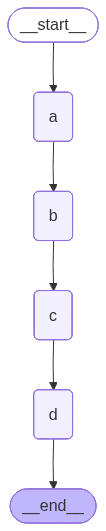

In [17]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
import numpy as np
class MyState(TypedDict):
    state1:Annotated[np.ndarray,operator.add]

class ReturnNodeValue:
    def __init__(self,value:str):
        self.value=value
    def __call__(self,state:MyState)->MyState:
        print(f"Returning {self.value} to {state['state1']}")
        return {"state1":np.array(self.value)}

builder=StateGraph(MyState)
builder.add_node("a",ReturnNodeValue("I am A"))
builder.add_node("b",ReturnNodeValue("I am B"))
builder.add_node("c",ReturnNodeValue("I am C"))
builder.add_node("d",ReturnNodeValue("I am D"))

builder.add_edge(START,"a")
builder.add_edge("a","b")
builder.add_edge("a","c")
builder.add_edge("b","d")
builder.add_edge("c","d")
builder.add_edge("d",END)

graph=builder.compile()

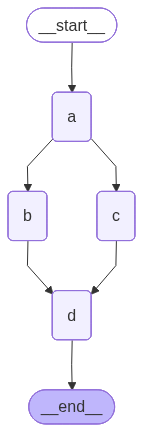

In [30]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state1":np.array("")})
except InvalidUpdateError as e:
    print(e)


Returning I am A to 
Returning I am B to I am A
Returning I am C to I am A
Returning I am D to I am AI am BI am C


In [64]:
def sorting_reducer(left, right):
    # Handle 0-d arrays
    if isinstance(left, np.ndarray) and left.ndim == 0:
        left = np.array([left.item()])
    elif not isinstance(left, np.ndarray):
        left = np.array([left])
    
    if isinstance(right, np.ndarray) and right.ndim == 0:
        right = np.array([right.item()])
    elif not isinstance(right, np.ndarray):
        right = np.array([right])
    
    # Fix concatenate - it needs a sequence, not individual args
    combined = np.concatenate([left, right])
    return np.array(sorted(combined))

In [65]:
import numpy as np
class MyState(TypedDict):
    state1:Annotated[np.ndarray,sorting_reducer]

class ReturnNodeValue:
    def __init__(self,value:str):
        self.value=value
    def __call__(self,state:MyState)->MyState:
        print(f"Returning {self.value} to {state['state1']}")
        return {"state1":np.array(self.value)}

builder=StateGraph(MyState)
builder.add_node("a",ReturnNodeValue("I am A"))
builder.add_node("b",ReturnNodeValue("I am B"))
builder.add_node("c",ReturnNodeValue("I am C"))
builder.add_node("d",ReturnNodeValue("I am D"))
builder.add_node("b2",ReturnNodeValue("I am B2"))
builder.add_edge(START,"a")
builder.add_edge("a","b")
builder.add_edge("a","c")
builder.add_edge("b","b2")
builder.add_edge("b2","d")
builder.add_edge("c","d")
builder.add_edge("d",END)

graph=builder.compile()

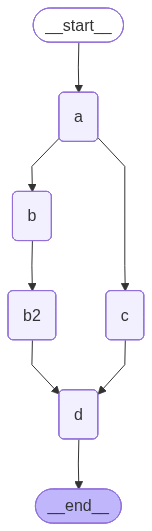

In [66]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))


In [67]:
try:
    graph.invoke({"state1":np.array("")})
except Exception as e:
    print(f"Error: {e}")


Returning I am A to 
Returning I am C to ['' 'I am A']
Returning I am B to ['' 'I am A']
Returning I am D to ['' 'I am A' 'I am B' 'I am C']
Returning I am B2 to ['' 'I am A' 'I am B' 'I am C']
Returning I am D to ['' 'I am A' 'I am B' 'I am B2' 'I am C' 'I am D']


# **Parallelism in Langgraph**


In [5]:
from typing import TypedDict,Annotated
import operator
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()



llm=ChatOpenAI(model="gpt-4o-mini",temperature=0,api_key=os.getenv("OPENAI_API_KEY"))

class ParallelState(TypedDict):
    question:str
    answer:str
    context:Annotated[list,operator.add]

In [23]:
from langchain_core.messages import HumanMessage,SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_tavily import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

# search=TavilySearchResults(max_results=4)
search=TavilySearchResults(max_results=4)

def web_search(state: ParallelState) -> ParallelState:
    docs = search.invoke(state["question"])
    print(f"DEBUG: docs types: {type(docs)},first item: {docs[0] if docs else 'No docs'}")
    
    formatted_search_docs = "\n\n----\n\n".join(
        f"<Document href={doc.get('url', 'N/A')}/>\n{doc.get('content', doc.get('snippet', str(doc)))}"
        for doc in docs
    )
    
    return {"context": [formatted_search_docs]}



def wiki_search(state: ParallelState) -> ParallelState:
    docs = WikipediaLoader(query=state["question"]).load()
    # WikipediaLoader returns Document objects with .page_content and .metadata
    formatted_wiki_docs = "\n\n----\n\n".join(
        f"<Document href={doc.metadata.get('source', 'N/A')}/>\n{doc.page_content}" 
        for doc in docs
    )
    
    return {"context": [formatted_wiki_docs]}

def generate_answer(state:ParallelState)->ParallelState:
    question=state["question"]
    context=state["context"]
    
    answer_template=f"""Answer the question using this context:{context}"""
    answer_instructions=answer_template.format(question=question,context=context)
    
    llm=ChatOpenAI(model="gpt-4o-mini",temperature=0)
    answer=llm.invoke([SystemMessage(content=answer_instructions),HumanMessage(content=f"Answer the following question: {question}")])
    
    return {"answer":answer}

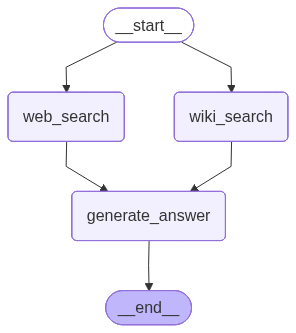

In [24]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
builder=StateGraph(ParallelState)
builder.add_node("web_search",web_search)
builder.add_node("wiki_search",wiki_search)
builder.add_node("generate_answer",generate_answer)

builder.add_edge(START,"web_search")
builder.add_edge(START,"wiki_search")
builder.add_edge("web_search","generate_answer")
builder.add_edge("wiki_search","generate_answer")
builder.add_edge("generate_answer",END)

graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
result=graph.invoke({"question":"What is the latest updates in AI?"})
print(result["answer"].content)

DEBUG: docs types: <class 'list'>,first item: {'title': 'The latest AI news we announced in September - Google Blog', 'url': 'https://blog.google/technology/ai/google-ai-updates-september-2025/', 'content': "# The latest AI news we announced in September\n\nOct 08, 2025\n\nHere’s a recap of some of our biggest AI updates from September, including an AI upgrade for Chrome, a new visual search option in AI Mode and the next step in bringing helpful robots into the physical world.\n\nSuperG\n\n## General summary [...] Forget pumpkin spice; the real news from September was the massive stack of AI updates. AI delivered major updates across our most popular core services like Chrome, Search and Android, making them significantly smarter. And the Gemini app became a powerhouse with its latest Gemini Drop, featuring the viral Nano Banana, Gemini Live, custom and shareable Gems, and the no-code app-building tool, Canvas. Meanwhile, even as we integrate AI across our digital products, Google Dee

# **SubGraphs**


In [5]:
from operator import add
from typing import TypedDict,Annotated
from langgraph.graph import StateGraph,START,END

class JobState(TypedDict):
    name: Annotated[list[str], add]
    job: str

def job_node(state):
    return {"job": "DevOps Engineer"}

def job_dummy_node(state):
    pass

class LocationState(TypedDict):
    name: Annotated[list[str], add]
    location: str

def location_node(state):
    return {"location": "Bangalore"}

def location_dummy_node(state):
    pass

job_builder = StateGraph(JobState)
job_builder.add_node("job_node", job_node)
job_builder.add_node("job_dummy_node", job_dummy_node)
job_builder.add_edge(START, "job_node")
job_builder.add_edge("job_node", "job_dummy_node")
job_builder.add_edge("job_dummy_node", END)
job_graph = job_builder.compile()

location_builder = StateGraph(LocationState)
location_builder.add_node("location_node", location_node)
location_builder.add_node("location_dummy_node", location_dummy_node)
location_builder.add_edge(START, "location_node")
location_builder.add_edge("location_node", "location_dummy_node")
location_builder.add_edge("location_dummy_node", END)
location_graph = location_builder.compile()

In [6]:
class ParentState(TypedDict):
    name: Annotated[list[str], add]
    job: str
    location: str
    details: str

def first_node(state: ParentState):
    return {"name": [state['name'][-1]]}

def last_node(state: ParentState):
    return {"details": f"{state['name'][-1]} is a {state['job']} at {state['location']}"}

In [15]:
entry_builder = StateGraph(ParentState)
entry_builder.add_node("first_node", first_node)
entry_builder.add_node("location_subgraph", location_graph)
entry_builder.add_node("job_subgraph", job_graph)
entry_builder.add_node("last_node", last_node)

entry_builder.add_edge(START, "first_node")
entry_builder.add_edge("first_node", "location_subgraph")
entry_builder.add_edge("first_node", "job_subgraph")
entry_builder.add_edge("location_subgraph", "last_node")
entry_builder.add_edge("job_subgraph", "last_node")
entry_builder.add_edge("last_node", END)

In [8]:
graph = entry_builder.compile()

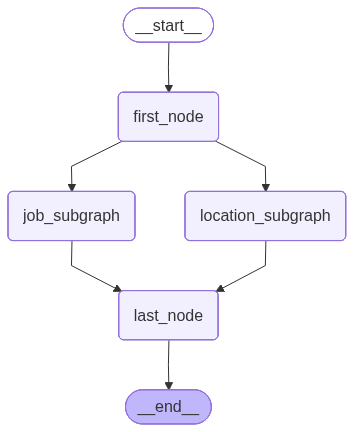

In [9]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))
